# Explainable AI (XAI)

## 03_SmoothGrad

##### Descrição
Sabemos que os modelos de Inteligência Artificial apresentam uma natureza do tipo caixa-preta (black-box).

É necessário compreender como as redes desenvolvidas realizam suas predições.

Existem alguns métodos de interpretabilidade que tentam explicar o processo de decisão dos modelos de AI.
Veremos alguns destes nos próximos Notebooks...




## Classificação de Imagens
Usaremos alguns métodos de XAI no modelo VGG16, que é uma rede convolucional amplamente conhecida e utilizada.

###### Os primeiros passos são iguais aos anteriores. O que altera é a função para gerar o smoothgrad

#### Carregando Bibliotecas

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import sys

In [2]:
print('...')
print('--> VERSOES')
print("Versao python:",sys.version)
print("Versao de tensorflow:",tf.__version__)
print("Versao de Numpy:", np.__version__)

...
--> VERSOES
Versao python: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Versao de tensorflow: 2.8.0
Versao de Numpy: 1.20.3


#### Carregando Modelo

In [3]:
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Carregando Imagem
Usaremos uma imagem baixada da internet, de uma das classes existentes no ImageNet.

Observe que o modelo VGG16 recebe como entrada uma imagem de tamanho 224x224x3.

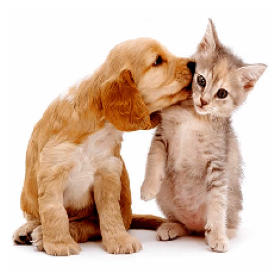

In [4]:
# Carregar imagem
original_img = load_img('../Images/catdog.jpg', target_size=(224, 224))

# Converter para um Numpy Array
image = np.asarray(np.array(original_img))

# Realiza o preprocessamento da imagem para ser utilizada na VGG16
X = preprocess_input(image)

# Plotar imagem de entrada
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
print('Image X shape:\n', X.shape, type(X))

Image X shape:
 (224, 224, 3) <class 'numpy.ndarray'>


#### Classificando imagem X

In [6]:
from keras.applications.imagenet_utils import decode_predictions

# Entrada do VGG16 é do tipo (None, 224, 224, 3). Então temos que expandir a dimensão da nossa entrada.
x_img = np.expand_dims(X, axis=0)

# Classificar a imagem x
preds = model.predict(x_img)

# Apresenta as 5 top predições 
print('Top5 Predições do modelo:')
for x in decode_predictions(preds)[0]:
    print(x)

Top5 Predições do modelo:
('n02099601', 'golden_retriever', 0.20480192)
('n02102318', 'cocker_spaniel', 0.1354943)
('n03223299', 'doormat', 0.06035429)
('n02124075', 'Egyptian_cat', 0.05699708)
('n02808304', 'bath_towel', 0.055041)


## SMOOTH GRAD
Calcula o gradiente da saída com relação a cada pixel da imagem de entrada. Ou seja, ele continua a backpropagação até a camada de entrada para "ver" quais pixels afetam mais a predição.
Diferente do Mapa de Saliencia anterior, o Smooth-Grad gera ruídos na imagem original, calcula os mapas de saliência e então calcula a média desses mapas gerados com os ruidos na imagem de entrada.

#### Importando bibliotecas para gerar o SmoothGrad

In [10]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

#### Definindo funções para gerar o Grad-Cam

In [11]:
# ------------------------------------------------- #
def getTopPred(model, x_img):
    '''
    Realiza a predição da imagem x_img utilizando o modelo de classificação
    Retorna o índice das classes ordenadas
    

    Args:
      model: tf model
      x_img: float32 numpy array with shape (None x img_width x img_height x 3)


    Returns 
      int

    '''
    pred = np.squeeze(model.predict(x_img))
    top_preds = pred.argsort()[-5:][::-1] # índice das classes ordenadas
    return top_preds        
    
# ------------------------------------------------- #
def getScore(top_pred, i):
    '''
    Retorna o valor do Score da classe "i" indicada pelo seu índice
    #https://keisen.github.io/tf-keras-vis-docs/api/tf_keras_vis.utils.scores.html
    

    Args:
      top_pred: int
      i: int


    Returns 
      tf_keras_vis.utils.scores.CategoricalScore

    '''
    return CategoricalScore(top_pred[i]) 
    #return BinaryScore(top_pred[i]) # Caso a classificação seja binária

# ------------------------------------------------- #
def getSmoothGrad(model, x_img, score):
    '''
    Aplica o método SmoothGrad em uma instância, dado o modelo de predição
    

    Args:
      model: tf model
      x_img: float32 numpy array with shape (None x img_width x img_height x 3)
      score: tf_keras_vis.utils.scores.CategoricalScore


    Returns 
      float32 numpy array with shape (1 x img_width x img_height) that is the Vanilla Saliency

    '''
    
    #Substitui a função de ativação da ultima camada para uma função linear
    replace2linear = ReplaceToLinear()
    
    # Create Saliency object.
    saliency = Saliency(model,
                        model_modifier=replace2linear,
                        clone=True)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(score,
                            x_img,
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.

    return saliency_map

### Aplicando SmoothGrad
Vamos aplicar o SmoothGrad à primeira predição do modelo, que corresponde a classe:
- golden_retriever

Observe que o SmoothGrad mostra que alguns pontos correspondente ao cachorro. Veja como seu resultado é muito melhor que o gerado pelo mapa de saliencia

In [12]:
preds = getTopPred(model, x_img) # get top5 predict

score = getScore(preds,0) # get 1st predicted

saliency_map = getSmoothGrad(model, x_img, score) # get SmoothGrad

#### Plotando imagem

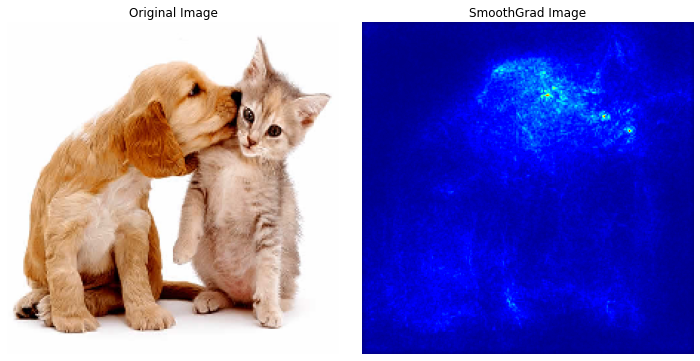

In [13]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image)
ax2.imshow(saliency_map[0], cmap='jet')
ax2.set_title("SmoothGrad Image")
ax2.axis('off')

plt.tight_layout()
plt.show()
#fig.savefig('Smooth_1st_predicted')

### Aplicando SmoothGrad
Vamos aplicar o SmoothGrad à primeira predição do modelo, que corresponde a classe:
- Egyptian_cat

Observe que o Mapa de Saliencia mostra que alguns pontos correspondente ao gato

In [14]:
preds = getTopPred(model, x_img) # get top5 predict

score = getScore(preds,3) # get 4st predicted

saliency_map = getSmoothGrad(model, x_img, score) # get SmoothGrad

#### Plotando imagem

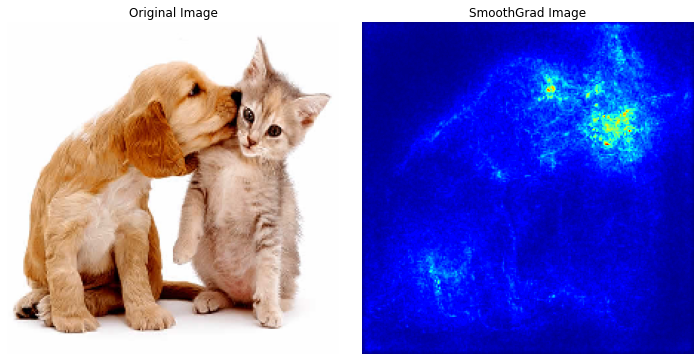

In [15]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis('off')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image)
ax2.imshow(saliency_map[0], cmap='jet')
ax2.set_title("SmoothGrad Image")
ax2.axis('off')

plt.tight_layout()
plt.show()
#fig.savefig('Smooth_4th_predicted')